# Missing Values Imputation

In [98]:
import pandas as pd
from sklearn.impute import SimpleImputer
from reparo import CDI,FRNNI ,HotDeckImputation,PMM,SICE,KNNImputer,MICE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

# Analyze data

In [99]:
df=pd.read_csv("data/kidney_disease.csv")

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [ ]:
def analyze_missingness(df):
    missing_percent = df.isnull().sum() / len(df) * 100
    print(missing_percent.sort_values(ascending=False).apply(lambda x: f"{x:.2f} %"))

null_val_percentage = analyze_missingness(df)

pot               22.00 %
sod               21.75 %
hemo              13.00 %
su                12.25 %
sg                11.75 %
al                11.50 %
bgr               11.00 %
bu                 4.75 %
sc                 4.25 %
bp                 3.00 %
age                2.25 %
ba                 0.00 %
pc                 0.00 %
rbc                0.00 %
id                 0.00 %
pcc                0.00 %
pcv                0.00 %
wc                 0.00 %
rc                 0.00 %
htn                0.00 %
dm                 0.00 %
cad                0.00 %
appet              0.00 %
pe                 0.00 %
ane                0.00 %
classification     0.00 %
dtype: object


## Plot NULL values from have in dataset


<Axes: title={'center': 'Number of Null Values in Each Column'}>

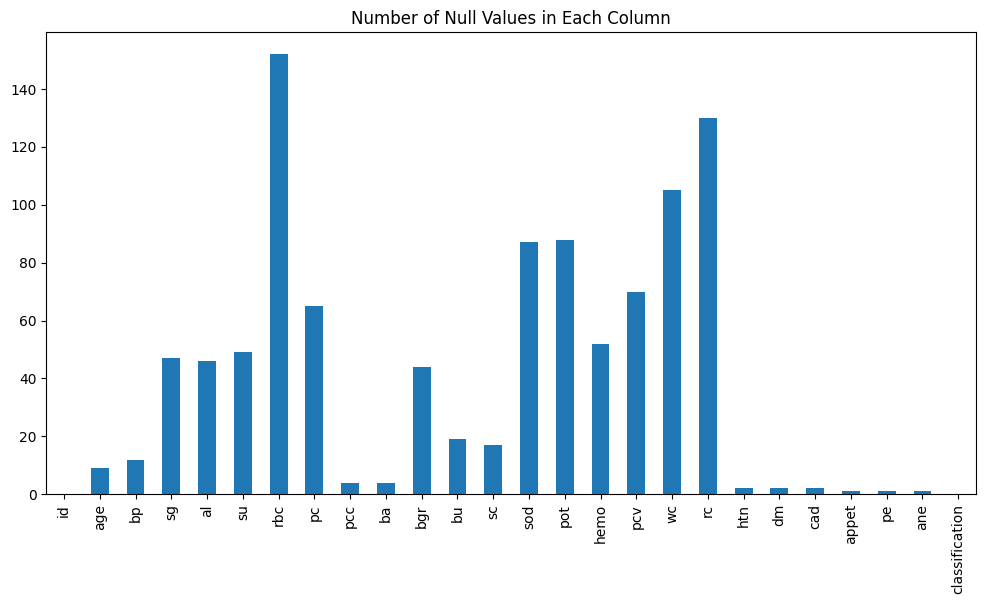

In [102]:
null_values=df.isnull().sum()
null_values.plot(kind='bar', figsize=(12, 6), title='Number of Null Values in Each Column')

## Encode data because used supervised algorithms do not work with categorical columns

In [103]:
def encode_object_columns(df):
    obj_cols=df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        le=LabelEncoder()
        df[col]=le.fit_transform(df[col])
    return df

df=encode_object_columns(df)

In [110]:
corr_matrix = df.corr()["classification"].abs().sort_values(ascending=False)
corr_matrix

classification    1.000000
id                0.836704
hemo              0.766832
sg                0.729117
al                0.625585
htn               0.543271
bgr               0.419245
bu                0.382920
sod               0.375461
dm                0.366016
appet             0.359114
pe                0.352622
pcv               0.349749
su                0.345589
sc                0.300894
bp                0.297019
ane               0.293151
rbc               0.238042
age               0.222361
cad               0.155347
pcc               0.149153
pc                0.114674
wc                0.102709
pot               0.085035
rc                0.071121
ba                0.057511
Name: classification, dtype: float64

## Training and Testing

In [ ]:
target_col="classification"
id_col="id"
X = df.drop(columns=[target_col,id_col])
y = df[target_col]

# Dropped column ID because it was the most correlated feature, is a major red flag and it seems 
# like the dataset was created in a such way , also I tryed to make df.sample(frac=1) but it doesn't change the situation

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

imputers = {
        'Median': SimpleImputer(strategy='median'),
        'Mean': SimpleImputer(strategy='mean'),
        'Most Frequent': SimpleImputer(strategy='most_frequent'),
        'Constant (0)': SimpleImputer(strategy='constant', fill_value=0),
        'CDI': CDI(),
        'FRNNI': FRNNI(),
        'Hot Deck': HotDeckImputation(),
        'KNN': KNNImputer(),
        'PMM': PMM(),
        'SICE': SICE(),
        'MICE': MICE()
    }
    
algorithms = {
        'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
        'Gaussian Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42)
    }

results = []

for imp_name, imputer in imputers.items():
    try:
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        for clf_name, clf in algorithms.items():
            clf.fit(X_train_imputed, y_train)
            y_pred = clf.predict(X_test_imputed)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted')

            results.append({
                'Imputation Algorithm': imp_name,
                'Prediction Algorithm': clf_name,
                'Accuracy': acc,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })
    except Exception as e:
        print(f"Error with {imp_name}: {str(e)}")
        continue

results_df = pd.DataFrame(results)

results_df


d:\Sigmoid_Intership\Sigmoid_Homework\.venv\Lib\site-packages\reparo\PMM.py:80: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  beta_zviozdacika = np.random.multivariate_normal(


,Imputation Algorithm,Prediction Algorithm,Accuracy,Precision,Recall,F1 Score
0,Median,Logistic Regression,0.9875,0.987745,0.983333,0.987456
1,Median,Gaussian Naive Bayes,0.8750,0.896591,0.591111,0.881588
2,Median,Decision Tree,0.9375,0.963235,0.620000,0.949323
3,Median,Random Forest,0.9625,0.964623,0.950000,0.962059
4,Mean,Logistic Regression,0.9875,0.987745,0.983333,0.987456
5,Mean,Gaussian Naive Bayes,0.8750,0.896591,0.591111,0.881588
6,Mean,Decision Tree,0.9250,0.962500,0.613333,0.942763
7,Mean,Random Forest,0.9750,0.975962,0.966667,0.974814
8,Most Frequent,Logistic Regression,0.9750,0.987500,0.648889,0.981144
9,Most Frequent,Gaussian Naive Bayes,0.8750,0.896591,0.591111,0.881588


# Imputation Algorithms

#### 1️⃣***SimpleImputer(strategy='median')***: Replaces missing values ​​with the median of the column. Useful for outliers if there are few.

#### 2️⃣***SimpleImputer(strategy='mean')***: Replaces missing values ​​with the mean of the column. Sensitive to outliers.

#### 3️⃣ ***SimpleImputer(strategy='most_frequent')***: Replaces missing values ​​with the most frequent value (mode) in the column. Useful for categorical or numeric data.

#### 4️⃣ ***CDI()*** (Central Difference Imputation): A more advanced method that replaces missing values ​​based on differences between neighbors. It is suitable for ordered data or time series.

#### 5️⃣ ***FRNNI()*** (Fuzzy Rough Nearest Neighbor Imputation): A method based on nearest neighbors somewhat similar to CDI.

#### 6️⃣ ***HotDeckImputation():*** Replaces missing values ​​with observed values ​​of other "similar" instances in the data set.

#### 7️⃣ ***KNNImputer():*** Imputes missing values ​​using the mean (or median) of the values ​​of the k-nearest neighbors in the data set.

#### 8️⃣***PMM()*** (Predictive Mean Matching): Models the complete data to predict missing values ​​and then chooses "matching" observed values ​​to replace them.

#### 9️⃣ ***SICE()*** (Sequential Imputation by Conditional Expectation): Another iterative imputation method that models the conditional distribution of variables with missing values ​​and imputes them sequentially.

#### 🔟***MICE()*** (Multivariate Imputation by Chained Equations): A sophisticated iterative imputation technique. For each variable with missing values, a regression model is trained on the other variables in the data set to predict the missing values. This process is repeated multiple times.

## 💡 Tips
- For small to medium datasets with complex relationships: Try MICE or PMM
- For large datasets where speed matters: Use FRNNI or KNNImputer
- For mixed data types: CDI often performs well
- For maintaining data integrity: HotDeckImputation or PMM
- For structured data: SICE is specifically designed for this

# ✅Conclusion

### I obtained really good results maybe even too good but I analyzed and it seems I didn't miss anything from what I know that would affect the accuracy of the results. Really really good algorithms until now I thought it was more difficult to get good results if the dataset has null values

**Precision** - Of all the instances that the model predicted to be positive, how many were actually positive? 
$$\text{Precision} = \frac{TP}{TP + FP}$$

**Recall**  - is similar to precision score, out of all the instances that were truly positive, how many the model managed to correctly identify 
$$\text{Recall} = \frac{TP}{TP + FN}$$

**F1 Score** - weighted harmonic mean of precision and accuracy
$$F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

